#                        Bayesian methods of Machine Learning. (Skoltech)

##         Home assignment 1. ARD regression.  EM-algorithm. 

<img src="https://go2phystech.ru/wp-content/uploads/2021/02/skolteh.jpeg" width=800 height=200 />

### Important information

$\textbf{Deadline}$: 23:59:59, 20 October 2023 (Friday)\
$\textbf{Rules}$:
- Do not redistribure materials of this homework, they belong to Skoltech.
- This is your individual work. Please, do not consult with the other students and do not copy their work. Otherwise, you will get 0 points.
- Please, respect the homework deadlines!
- This HW is composed of 4 tasks with the corresponding points: task 1 - 1pt, task 2 - 4 pts, task 3 - 3 pts, task 2 - 2pts.
- We have created a special telegram topic for this homework 1. There you can questions if anything is unclear. However, please do not post your solution or ask for it in the subgroup's messages, otherwise, you will get 0 points.
- After the grades are posted, you will have one week to appeal (offline, on campus).


Author : Kolesov Alexander

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as TD
import torch.optim as optim

import numpy as np
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score
from IPython.display import Image, display
from IPython.core.display import HTML
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

<img src="https://i.pinimg.com/736x/1c/21/d2/1c21d2bd14896107ad9f8b98892ea139.jpg" width=300 height=100 />

## Task 1. Test (1 pt)

The first block is composed of questions, which have been discussed during the seminars. Even though simple, they are crucial for understanding the main concepts of BML. Each of the correct answers costs $\textbf{0.2}$ points. You should write down your answer in the corresponding cells that are located below.

### Question 1.1 (0.2 pts):
Are Cauchy and Gumbel distributions conjugate?

##### No


### Question 1.2 (0.2 pts):
Why do we use Gaussian distribution as a prior for Bayesian Linear regression?

##### Our Likelihood is Gaussian, prior conjugate for Gaussian is Gaussian => Posterior will be Gaussian => easy to compute

### Question 1.3 (0.2 pts):
In which case does Bayesian Linear regression coincide with the Ordinary Linear Regression?

##### Our prior is $\mathcal{N}(w|0, A^{-1})$, where $A = \alpha I$. If we set $\alpha \rightarrow 0$ we obtain Ordinary Linear Regression. (So basically with uniform prior).

### Question 1.4 (0.2 pts):

How to find the covariance matrix $\Sigma$, when you know the quadtaric form of $\log p(w|X,y,\alpha,\beta)$ ?

##### $\Sigma = - \left[\frac{\partial ^ 2}{\partial w^2}  \log p(w|X,y,\alpha,\beta) \right]^{-1}$

### Question 1.5 (0.2 pts):

What does the term $\int_{z} q(z)\log\frac{q(z)}{p(z|X,\theta)}dz$ in variational inference mean ?

##### $q(z)$ is our prior knoweledge, $p(z|X,\theta)$ is our knoweldge after obtaining samples X, so this term is KL divergence between our prior knowledge and the obtained one. (How good our prior is)

## Task 2. ARD-regression (4 pts)

The following task deals with the $\textbf{Automatic Relevance Determination}$ (ARD) regression, the ingredients of which are:

- Likelihood of one item: $p(y_n|x_n, w;\beta) = \mathcal{N}(y_n| \textbf{w}^Tx_n, \beta^{-1})$
- Likelihood model for the whole data: $p(\textbf{y}|X,\textbf{w};\beta) = \prod\limits_{n=1}^{N}p(y_n|x_n,\textbf{w};\beta) = \mathcal{N}(\textbf{y}|X\textbf{w}, \beta^{-1})$
- Prior model: $p(\textbf{w};\alpha) = \prod\limits_{d=1}^{D}\mathcal{N}(w_d|0, \alpha_d^{-1})=\mathcal{N}(\textbf{w}|0,A^{-1})$

Thus, the Bayesian model has two hyper-parameters. While $\beta$ is a value that describes variance of the **Likelihood model**, $\alpha$ is a vector of the diagonal elements of matrix $A$. The goal of the ARD regression is to maximize evidence by tuning parameters $\alpha$ (corresponding to each of the data features) and value $\beta$.

We have already achieved the following results during one of our seminars:

\begin{equation*}
\begin{aligned}
& \mu^{new} = \beta(\beta X^T X + A)^{-1}X^T\textbf{t},\\
& \alpha_i^{new} = \frac{1}{\mu^2_i}(1-\Sigma_{ii}^{old}\alpha_i^{old}),\\
& \beta^{new} = \frac{1}{\|t-X\mu\|_2^2}\left(N-\text{trace} (I-\Sigma^{old}A^{old})\right),\\
& \Sigma^{new} = (\beta^{new} X^TX + A^{new})^{-1}.\\
\end{aligned}
\end{equation*}

### Task 2.1. Missing code (2 pts)

You should familiarize yourself with the code located below for the ARD class and :

- fill in the missing code for the $\it{get}$ _ $\it{alpha}$ function -- (**1 pt**)
- fill in the missing code for the $\it{get}$ _ $\it{beta}$ function --  (**1 pt**)

In [2]:
class ARD:
    
    def __init__(self, X, y,  beta_0, alpha_0, iters, threshold):
        
        """
        X - shape([N,D])
        y - shape([N,])
        beta_0 - float: variance for likelihood
        alpha_0 - float: diagonal elements of prior matrix
        """
        self.X = X
        self.y = y
        
        # parameters for likelihood model
        self.beta = beta_0
        
        # parameters for prior distribution
        # set diagonal elements of cov matrix
        self.alpha = np.array([alpha_0] * self.X.shape[1]) #[D,]
        
        # necessary calculus
        self.data_cov = self.X.T @ self.X # [D,D]
        self.data_mean = self.X.T @ self.y # [D,1]
        
        # training necessities
        self.iters = iters
        self.threshold = threshold
        self.idx_relevant = np.array(range(self.X.shape[1]))
        
    def get_sigma(self):
        """
        calculating covariance matrix of log p(w|x,y)
        """
        return np.linalg.inv(self.beta * self.data_cov + np.diag(self.alpha)) 
    
    
    def get_mu(self):
        """
        calculating expectation of log p(w|x,y)
        """
        return self.beta * self.sigma @ self.data_mean
     
        
    def get_alpha(self, alpha, mu, sigma):
        """
        update alpha
        
        alpha - shape([D,])
        mu    - shape([D,1])
        sigma - shape([D,D])
        """ 
        return (1 - sigma.diagonal() * alpha) / (mu ** 2)
         
    
    
    def get_beta(self, alpha, mu, sigma):
        """
        update beta 
        
        alpha - shape([D,])
        mu    - shape([D,1])
        sigma - shape([D,D])
        """
        
        N, D = self.y.size, alpha.size
        return (N - np.trace(np.eye(D) - sigma @ alpha)).sum() / (np.linalg.norm(self.y - self.X @ self.mu) ** 2)
        
            
            
    def prune(self):
        
        """
        Pruning function to remove non-informative features
        
        """
         
        idx = np.where(self.alpha < self.threshold)[0]
        
        if len(idx) != 0:
            bad = np.where(self.alpha >= self.threshold)[0]
            temp = self.idx_relevant[np.where(self.idx_relevant != -1)] 
            temp[bad] = -1
            self.idx_relevant[np.where(self.idx_relevant != -1)] = temp
            
            self.X = self.X[:, idx]
            self.alpha = self.alpha[idx]
            self.mu = self.mu[idx]
            self.data_cov, self.data_mean = self.X.T @ self.X, self.X.T @ self.y 
            
    def elbo(self):
        """
        metric for the method
        """
        N = self.X.shape[0]
        lbound = N * np.log(self.beta) + np.sum(np.log((self.alpha))) -\
        self.beta * np.linalg.norm(self.X @ self.mu - self.y) ** 2\
        - np.sum(self.mu ** 2 * self.alpha) + np.log(np.linalg.det(self.sigma))
        return lbound
    
    def fit(self,prune):
        """
        training function
        """
        for i in range(self.iters):
            self.sigma = self.get_sigma()
            self.mu = self.get_mu()
            self.alpha = self.get_alpha(self.alpha, self.mu, self.sigma)
            self.beta = self.get_beta(self.alpha, self.mu, self.sigma)
              
            if prune is not None:
                self.prune()
            else:
                self.alpha = np.clip(self.alpha, 0., 1e5)
                
            #print(i, self.elbo())
            
        return self.mu, self.sigma, self.alpha, self.beta
    
    def get_relevant_features_prune(self):
        return self.idx_relevant[np.where(self.idx_relevant != -1)]   

### Task 2.2 Tracking method for finding informative features. (0.5 pts)

In this task, we will use the artificial data generated with the ```make_regression``` function from [scikit.learn](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html), setting the number of meaningful features to $3$. To make predictions and find the most informative features we are going to be using your completed implementation of the ARD class.

In this task you will need to 
- Try out different values for the ```alpha_0```, ```beta_0```, ```iters``` and ```threshold``` parameters of the ARD model using the coreresponding lists below and explain your observations (**0.25 pts**)
- How will the result of this task change if $\alpha$ and $\beta$  are approaching 0 and $\infty$? Consider all 4 possible combinations:  $\alpha \rightarrow  0$, $\beta \rightarrow  0$; $\alpha \rightarrow  0$, $\beta \rightarrow  \infty$; ... etc (**0.25 pts**)

In [3]:
BETA_0 = [0.0001, 0.001, 0.1, 1., 10., 10_000]
ALPHA_0 = [0.0001, 0.001, 0.1, 1., 10., 10_000]
ITERS = [1,10,100,1_000]
THRESHOLD = [1e15,1e5,1e1,1,10]

In [4]:
X, t, coef_true = make_regression(100, 100, n_informative=3, coef=True)
print("=====================================================")
print("weights : ", coef_true)
print("=====================================================")
print("informative features : ",np.where(coef_true != 0)[0])

weights :  [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         92.55903315
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 44.89037308  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.  

You should take all possible combinations of ```alpha_0```, ```beta_0```, ```iters``` and ```threshold``` from the lists $\textbf{BETA}_0$ , $\textbf{ALPHA}_0$ , $\textbf{ITERS}$, $\textbf{THRESHOLD}$ and fit the resulting model.

In [5]:
reg = ARD( X, t, beta_0=10_0000000000000,
          alpha_0=10_0000000000000,
          iters=15,
          threshold=1e15
          )

In [6]:
mu, sigma, alpha, beta = reg.fit(True)

In [7]:
reg.get_relevant_features_prune()

array([23, 54, 96])

In [8]:
print(mu)
print(sigma)
print(alpha, beta)

[92.55903315 44.89037308 78.18911848]
[[ 1.35607153e-29  3.22789847e-31  1.33114432e-30]
 [ 3.22789847e-31  1.51064080e-29 -7.22216755e-31]
 [ 1.33114432e-30 -7.22216755e-31  1.75410209e-29]]
[0.00011672 0.00049624 0.00016357] 1.485978352679824e+27


In [9]:
# Your observations for all possible combinations of the aforementioned parameters and the 
# answer for Task 2.2 is here

Taking small number of iterations (<=3) with high th results in all features present. However even with th=1e15 5 iterations is enough for ard to converge and only relevant features are present. <br>
For reasonable values of $\alpha$ and $\beta$ algorithm converges succsesfully. However for $\beta = 10000$ algorithm explodes


How will the result of this task change if $\alpha$ and $\beta$  are approaching 0 and $\infty$? Consider all 4 possible combinations:  $\alpha \rightarrow  0$, $\beta \rightarrow  0$; $\alpha \rightarrow  0$, $\beta \rightarrow  \infty$; ... etc 

Tested with iters=5 and th=1e15 <br>
If $\alpha \rightarrow 0$ and $\beta \rightarrow 0$ algorithm converges succsesfully for th=1e5, iters=5. <br>
If $\alpha \rightarrow 0$ and $\beta \rightarrow \infty$ algorithm converges succsesfully for th=1e1, iters=1. <br>
If $\alpha \rightarrow \infty$ and $\beta \rightarrow 0$ algorithm fails beceuse sigma becomes singular for large num of ites. Fos small num of iters it fails to converge. <br>
If $\alpha \rightarrow \infty$ and $\beta \rightarrow \infty$ algorithm converges succsesfully for higher number of iters (15). (also we should lower the th to 1) <br>

### Task 2.3 Comparison to ML solutions in polynomial tasks. (1.5 pts)



In [10]:

def gen_batch(n, w, beta):
    """
    funciton for creating a batch along polynomial function
    """
    d = len(w)
    X = np.random.uniform(-1, 1, (n, 1))
    X = np.sort(X, axis=0)
    X = np.hstack([X ** i for i in range(d)])
    t = X.dot(w) + np.random.normal(size=n) / beta ** 0.5
    return X, t

In [11]:
n = 200
d = 21
w_true = np.zeros(d)
w_true[1] = 1
w_true[3] = -1
beta_true = 100

# train , test
X_train, t_train = gen_batch(n, w_true, beta_true)
X_test, t_test = gen_batch(n, w_true, beta_true)

In [12]:
X_train.shape, t_train.shape, X_test.shape , t_test.shape

((200, 21), (200,), (200, 21), (200,))

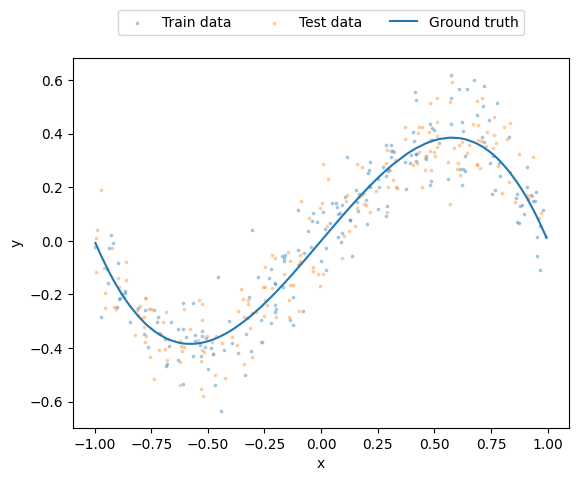

In [13]:
# Visualization of data
fig, ax = plt.subplots()
ax.scatter(X_train[:, 1], t_train, s=3, label='Train data', alpha=0.3)
ax.scatter(X_test[:, 1], t_test, s=3, label='Test data', alpha=0.3)
ax.plot(X_train[:, 1], X_train.dot(w_true), label='Ground truth')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.15))
plt.show()

In [27]:
reg = ARD( X_train, t_train, beta_0=10000,
          alpha_0=0.0001,
          iters=20,
          threshold=1e15
         )

In [28]:
w_rvr, sigma_rvr, alpha_rvr, beta_rvr = reg.fit(True)

In [29]:
w = np.zeros(X_train.shape[-1])
w[reg.get_relevant_features_prune()] = w_rvr
w_rvr=w

In [31]:
np.count_nonzero(w_rvr)

14

In [30]:
def l2_error(X, t, w):
    return np.sum((X.dot(w.ravel()) - t) ** 2)

In [19]:
from itertools import product
from tqdm.notebook import tqdm
best_sc = 1
for b, a, it, th in tqdm(product(BETA_0, ALPHA_0, ITERS, THRESHOLD)):
    try:
        reg = ARD( X_train, t_train, beta_0=b,
                alpha_0=a,
                iters=it,
                threshold=th
                )
        w_rvr, sigma_rvr, alpha_rvr, beta_rvr = reg.fit(True)
        w = np.zeros(X_train.shape[-1])
        w[reg.get_relevant_features_prune()] = w_rvr
        w_rvr=w
        #print(l2_error(X_train, t_train, w_rvr) / n)
        if l2_error(X_train, t_train, w_rvr) / n < best_sc:
            best_sc = l2_error(X_train, t_train, w_rvr) / n
            best = (b, a, it, th)
    except:
        continue
print('Best params', best)
print('Train error', best_sc)

0it [00:00, ?it/s]

Best params (10000, 0.0001, 1, 1000000000000000.0)
Train error 0.00951744556853824


#### Training Ridge regression

In [24]:
# Ridge Regression with Cross-Validation
from sklearn.linear_model import RidgeCV
ridge = RidgeCV(cv=20, alphas=10.**np.linspace(-6, 3, 100),
                fit_intercept=False).fit(X_train, t_train)
w_ridge = ridge.coef_

#### Training Lasso regression

In [25]:
# Lasso Regression with Cross-Validation
from sklearn.linear_model import LassoCV, Lasso
lasso = LassoCV(cv=5, alphas=10.**np.linspace(-6, 3, 100),
                fit_intercept=False, max_iter=2000000).fit(X_train, t_train)
w_lasso = lasso.coef_

### Your task

* Similarly to the previous task 2.2, find such values for the missing parameters of the ```ARD``` model (```alpha_0```, ```beta_0```, ```iters``` and ```threshold```) from the avaliable lists $\textbf{BETA}_0$ , $\textbf{ALPHA}_0$ , $\textbf{ITERS}$, $\textbf{THRESHOLD}$, so that the resulting ```l2_error``` on the **train set** is the lowest.
* Fill in the missing code below by adding the calcualtions of the:

    - Number of features remaining (informative features)  for RVR (**0.25 pts**)
    - Number of features remaining (informative features)  for Lasso (**0.25 pts**)

Relevance Vector Regression
Features remaining: 14 / 21
Train error: 0.010108722249638803
Test error:  0.009118575936134042
--------------------------------------------------
Ridge Regression
Features remaining: NA (no sparsity)
Train error: 0.010044424110522301
Test error:  0.009274041978196278
--------------------------------------------------
Lasso Regression
Features remaining: 8 / 21
Train error: 0.010051219763519019
Test error:  0.009173945353564389


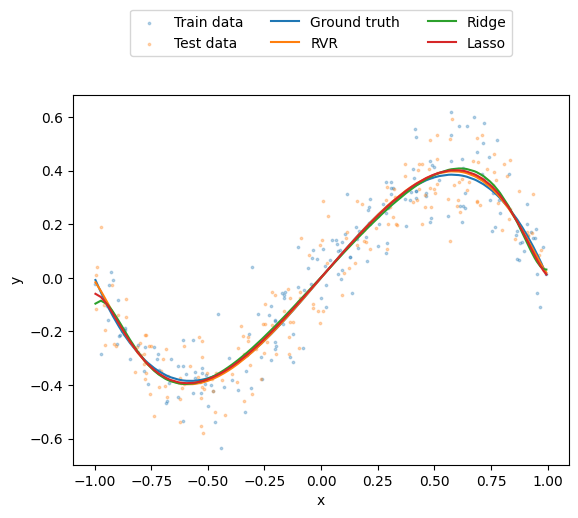

In [32]:
# Comparison
print('Relevance Vector Regression')
print('Features remaining:',  np.count_nonzero(w_rvr), '/', d)
print('Train error:', l2_error(X_train, t_train, w_rvr) / n)
print('Test error: ', l2_error(X_test, t_test, w_rvr) / n)
print('-'*50)
print('Ridge Regression')
print('Features remaining: NA (no sparsity)')
print('Train error:', l2_error(X_train, t_train, w_ridge) / n)
print('Test error: ', l2_error(X_test, t_test, w_ridge) / n)
print('-'*50)
print('Lasso Regression')
print('Features remaining:', np.count_nonzero(w_lasso), '/', d)
print('Train error:', l2_error(X_train, t_train, w_lasso) / n)
print('Test error: ', l2_error(X_test, t_test, w_lasso) / n)

fig, ax = plt.subplots()
ax.scatter(X_train[:, 1], t_train, s=3, label='Train data', alpha=0.3)
ax.scatter(X_test[:, 1], t_test, s=3, label='Test data', alpha=0.3)
ax.plot(X_train[:, 1], X_train.dot(w_true), label='Ground truth')
ax.plot(X_train[:, 1], X_train.dot(w_rvr), label='RVR')
ax.plot(X_train[:, 1], X_train.dot(w_ridge), label='Ridge')
ax.plot(X_train[:, 1], X_train.dot(w_lasso), label='Lasso')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.25))
plt.show()

Answer to the following question:
    
- Which of the methods has demonstrated the best results on the train/test set? Explain why do you think it has performed better than others? (**1 pt**)

###### Your answer is here

I was able to get the best results with RVR on the train set, then I increased iters from 1 to 20 and got the best result on the test set (on train it is the worst). I would say there results are random and to get precise understanding of which model is better you would need to run a lot more experiments. RVR may be better because our points are distributed as w_true @ x + noise, where noise is normal, so as we are predicting in rvr.

## Task 3. Variational EM algorithm for Gaussian Mixture Models (3 pts)

Let $X = X_{1},...,X_{n}$ be samples that are described by a parametric $k$-component GMM(Gaussian Mixture Model) distribution $p(x|\theta)$ with the following parameters $\theta = {\pi_{1:k},\mu_{1:k},\Sigma_{1:k}}$.

In the seminar, we have recalculated the parameters of the posterior distribution. Now, let the posterior distribution $q(z|x, \phi)$ be approximated by a neural network with its own parameters $\phi$. To make sure that this neural net describes a distribution, $\textbf{softmax}$ needs to be added as the final layer of this net.

Thus, we have two sets of parameters: $\phi$ of the posterior and $\theta$ of the GMM model.

We are looking for the distribution $q(z | x, \phi)$ and $\theta = \{ \boldsymbol{\pi}_{1:K}, \boldsymbol{\mu}_{1:K}, \boldsymbol{\Sigma}_{1:K} \}$ which maximizes the **ELBO** functional:

$$
L(q, \theta) = \int\limits_{\boldsymbol{Z}} q(\boldsymbol{z} | \boldsymbol{X}, \phi) \log \frac{p(\boldsymbol{X}| \boldsymbol{z}, \theta)p(\boldsymbol{z} | \theta)}{q(\boldsymbol{z} | \boldsymbol{X}, \phi)} d \boldsymbol{z} =\\= \sum\limits_{n = 1}^{N} \int\limits_{z_n} q(z_n | X_n, \phi) \log \frac{p(X_n | z_n, \theta) p(z_n | \theta)}{q(z_n | X_n, \phi)} d z_n =\\=
\sum\limits_{n = 1}^{N} \left(\int\limits_{z_n} q(z_n | X_n, \phi) \log p(X_n, z_n | \theta) d z_n - \int\limits_{z_n} q(z_n | X_n, \phi) \log q(z_n | X_n, \phi) d z_n\right) =\\=
\sum\limits_{n = 1}^{N} \Bigr( E_{z_n \sim q(z_n | X_n, \phi)} \log p(X_n, z_n | \theta) + H \bigl( q(z_n | X_n, \phi) \bigr) \Bigr)
$$


Thus, according to the theory behind the EM algorithm we have the following optimization procedure.

**E-step**

$\phi_{k + 1} = \phi_{k} + \eta \nabla_{\phi} L(q(\cdot| \boldsymbol{X}, \phi), \theta_k)|_{\phi=\phi_{k}}$

**M-step**

$\theta_{k + 1} = \theta_{k} + \eta \nabla_{\theta} \sum\limits_{n = 1}^{N} \Bigr( E_{z_n \sim q(z_n | X_n, \phi_{k + 1})} \log p(X_n, z_n | \theta)\Bigr) \Bigr|_{\theta = \theta_{k}}$

### 3.1 Utils function

In [33]:
DEVICE = 'cpu'
TICKS_FONT_SIZE = 12
LEGEND_FONT_SIZE = 12
LABEL_FONT_SIZE = 14
TITLE_FONT_SIZE = 16
np.random.seed(46)
torch.manual_seed(47)

In [34]:
def visualize_2d_densities(x_grid, y_grid, densities, title, xlabel=None, ylabel=None):
    densities = densities.reshape([y_grid.shape[0], y_grid.shape[1]])
    plt.figure(figsize=(5, 5))
    plt.pcolor(x_grid, y_grid, densities)
    plt.pcolor(x_grid, y_grid, densities)

    plt.title(title, fontsize=TITLE_FONT_SIZE)
    plt.xticks(fontsize=TICKS_FONT_SIZE)
    plt.yticks(fontsize=TICKS_FONT_SIZE)
    if xlabel is not None:
        plt.xlabel(xlabel, fontsize=LABEL_FONT_SIZE)
    if ylabel is not None:
        plt.ylabel(ylabel, fontsize=LABEL_FONT_SIZE)
    plt.show()

In [35]:
def draw_contour(density, X, Y, title, n_levels=3):
    plt.figure(figsize=(5, 5))
    density = density.reshape(X.shape)
    levels = np.linspace(np.min(density), np.max(density), n_levels)
    plt.contour(X, Y, density, levels=levels, c='red')
    plt.title(title, fontsize=16)
    plt.show()

def draw_distrib(distrib, title, n_levels=20, x_lim=(-11, 11), y_lim=(-11, 11),
                 dx=0.1, dy=0.1, device=DEVICE, contour=True, density=True):
    y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                    slice(x_lim[0], x_lim[1] + dx, dx)]
    mesh_xs = np.stack([x, y], axis=2).reshape(-1, 2)
    densities = torch.exp(distrib.log_prob(torch.tensor(mesh_xs).to(device))).detach().cpu().numpy()
    if contour:
        draw_contour(densities, x, y, title='{} contour'.format(title), n_levels=20)
    if density:
        visualize_2d_densities(x, y, densities, title='{} pdf'.format(title))

### 3.2 GMM class

It is the base class for the GMM model that defines the model of K-component GMM.

- function $\textit{gmm}$ creates a GMM
- function $\textit{init}$ intializes our model (means, weights and covarinces)
- funciton $\textit{prob_X_Zs}$ computes the matrix of probabilities $p(X, Z | \theta)$ that can be seen in the ELBO functional in the last formula above.

In [36]:
class GMM(nn.Module):
    
    @property
    def mu(self):
        return self._mu
    
    @mu.setter
    def mu(self, val):
        self._mu = nn.Parameter(val)

    @property
    def sigma(self):
        return self._L @ self._L.transpose(1, 2)
    
    @sigma.setter
    def sigma(self, val):
        self._L = nn.Parameter(torch.cholesky(val))

    @property
    def pi(self):
        return F.softmax(self._log_pi)

    @pi.setter
    def pi(self, val):
        assert val.min() > 0.
        val = val/torch.sum(val)
        self._log_pi = nn.Parameter(torch.log(val))

    @property
    def gmm(self):
        mix = TD.Categorical(self.pi)
        mv_normals = TD.MultivariateNormal(self.mu, scale_tril=self._L)
        gmm = TD.MixtureSameFamily(mix, mv_normals)
        return gmm

    
    def __init__(self, K, dim, mu=None, sigma=None, pi=None):
        '''
        Define a model with known number of clusters and dimensions.
        :Parameters:
            - K: Number of Gaussian clusters
            - dim: Dimension 
            - mu: means of clusters (K, dim)
                       (default) random from uniform[-10, 10]
            - sigma: covariance matrices of clusters (K, dim, dim)
                          (default) Identity matrix for each cluster
            - pi: cluster weights (K,)
                       (default) equal value to all cluster i.e. 1/K
        '''
        super().__init__()
        self.K = K
        self.dim = dim
        
        if mu is None:
            mu = np.random.rand(K, dim)*20 - 10
        self.mu = torch.tensor(mu) # (K, D)
        
        if sigma is None :
            sigma = np.zeros((K, dim, dim))
            for i in range(K):
                sigma[i] = np.eye(dim)
        self.sigma = torch.tensor(sigma) # (K, D, D)
        
        assert torch.allclose(self.sigma, torch.tensor(sigma))
        if pi is None:
            pi = np.ones(self.K)/self.K
        self.pi = torch.tensor(pi) # (K,)
        
    def log_prob(self, X):
        '''
        Computes the log-prob of each element in X
        input:
            - X: Data (batch_size, dim)
        output:
            - log-likelihood of each element in X: log Sum_k pi_k * N( X_i | mu_k, sigma_k ))
        '''
        return self.gmm.log_prob(X)
    
    def sample(self, shape):
        return self.gmm.sample(shape)
    
    def prob_X_Zs(self, X):
        '''
        Computes the matrix of probabilities p(X, Z | \theta)
        for all possible Z_i \in \{1, 2, \dots K\}
        :Parameters:
        X : tensor (N, D)
        :Output:
        out : tensor (N, K)
        '''
        mv_normals = self.gmm._component_distribution
        X_expanded = X.unsqueeze(-2).repeat(1, self.K, 1) # (N, K, 2)
        log_probs_unw = mv_normals.log_prob(X_expanded) # (N, K)
        log_probs_w = torch.exp(log_probs_unw) * self.pi.unsqueeze(0) # (N, K)
        return log_probs_w


Below, we define the ```GMM_VariationalEM``` class. This class will use the previously defined class ```GMM```.Note that $p(x,z|\theta)$ can be accessed when calling the function ```self.p_theta.prob_X_Zs```. 

### Task :
In order to calculate $H(q(Z|X,\phi))$ we need to approximate this distribution with a neural network. In this task you will need to:
- Define distribution $q$ as a neural network (**1 pt**)
- Fill in the missing line of code to calculate the ```log_p_x_zs``` in the ```ELBO_objective```function (**1 pt**)

In [37]:
class GMM_VariationalEM(nn.Module):
    
    # freeze parameters models
    @staticmethod
    def freeze(model):
        for p in model.parameters():
            p.requires_grad_(False)
        model.eval()

        
    #unfreeze parameters of model
    @staticmethod
    def unfreeze(model):
        for p in model.parameters():
            p.requires_grad_(True)
        model.train(True)
      
    
    @property
    def gmm_model(self):
        '''
        returns trained GMM model
        '''
        return self.p_theta

    
    
    def __init__(self, K, dim, mu=None, sigma=None, pi=None):
        '''
        Define a model with known number of clusters and dimensions.
        :Parameters:
            - K: Number of Gaussian clusters
            - dim: Dimension 
            - mu: means of clusters (K, dim)
            - sigma: covariance matrices of clusters (K, dim, dim)
            - pi: cluster weights (K,)
        '''
        super().__init__()
        # p_theta is p(x, z | theta)
        self.p_theta = GMM(K, dim, mu, sigma, pi)
        
        
        # model is done as Neural network model
        self.q =  nn.Sequential(
            nn.Linear(dim, 32),
            nn.LeakyReLU(),
            nn.Linear(32, K),
            nn.Softmax()
        )
        
    def ELBO_objective(self, X, E_step=False, reduction='sum'):
        '''
        Returns the full ELBO objective
        :Parameters:
        X : tensor (bs, D) : batch of samples
        '''
        eps = 1e-8 # we add eps to stabilize the learning and eliminate nan's 
        assert reduction in ['sum', 'mean']
        def reduction_func(x):
            return torch.sum(x) if reduction == 'sum' else torch.mean(x)
        Z_probs = self.q(X) # (bs, K)
        log_p_x_zs = torch.log(self.p_theta.prob_X_Zs(X) + eps)  #your code is here (!!!do not forget to add epsilon!!!) # (bs, K) p(x, z|\theta)
        elbo_without_entropy_components = torch.sum(Z_probs * log_p_x_zs, dim=-1) # (bs,)

        if not E_step:
            # we don't need entropy on M step
            return reduction_func(elbo_without_entropy_components)

        H_components = torch.sum( - Z_probs * torch.log(Z_probs + eps), dim=-1) # (bs,)
        elbo_components = elbo_without_entropy_components + H_components

        return reduction_func(elbo_components)

    def E_step_loss(self, X):
        self.freeze(self.p_theta)
        self.unfreeze(self.q)
       
        return - self.ELBO_objective(X, E_step=True, reduction='mean')

    def M_step_loss(self, X):
        self.freeze(self.q)
        self.unfreeze(self.p_theta)
        
        return - self.ELBO_objective(X, E_step=False, reduction='mean')



In [206]:
N_COMPONENTS = 12

/var/folders/hm/z2qrv1q973v1hnjbzpr42n3m0000gn/T/ipykernel_66176/3455873566.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self._log_pi)
/var/folders/hm/z2qrv1q973v1hnjbzpr42n3m0000gn/T/ipykernel_66176/3206462172.py:5: UserWarning: The following kwargs were not used by contour: 'c'
  plt.contour(X, Y, density, levels=levels, c='red')


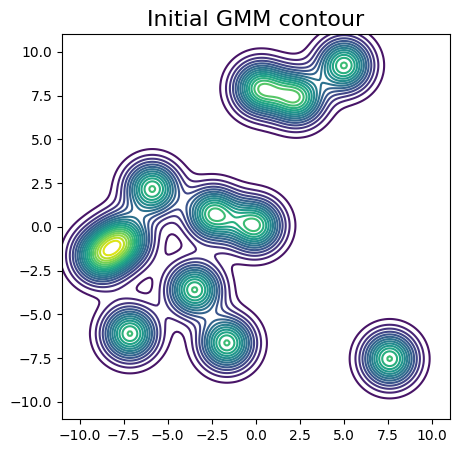

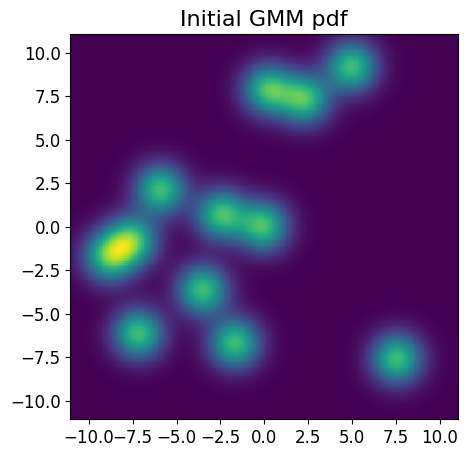

In [207]:
gmmEMVar = GMM_VariationalEM(N_COMPONENTS, 2).to(DEVICE)
draw_distrib(gmmEMVar.gmm_model, 'Initial GMM')

### 3.3 Train and test data

In [208]:
class FlowerGMM(GMM):

    def __init__(self):
        CENTERS_SCALE = 6.
        MAJOR_VAR = 3.
        MINOR_VAR = 1.
        r_angles = np.linspace(0., 2 * np.pi, 7, endpoint=False)
        vs = np.array([[np.cos(ang), np.sin(ang)] for ang in r_angles])
        perp_vs = np.array([[-np.sin(ang), np.cos(ang)] for ang in r_angles])
        mus = np.array([[0., 0.],] + [CENTERS_SCALE * v for v in vs])
        R_matrices = np.stack([vs, perp_vs], axis=1)
        petal_sigmas = np.array([[MAJOR_VAR, 0.], [0., MINOR_VAR]])[np.newaxis,...].repeat(7, axis=0)
        sigmas = np.concatenate([
            np.eye(2)[np.newaxis,...], 
            R_matrices.transpose(0, 2, 1) @ petal_sigmas @ R_matrices])
        super().__init__(8, 2, mu=mus, sigma=sigmas)
        # super().__init__(1, 2)
        
     

/var/folders/hm/z2qrv1q973v1hnjbzpr42n3m0000gn/T/ipykernel_66176/3455873566.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self._log_pi)
/var/folders/hm/z2qrv1q973v1hnjbzpr42n3m0000gn/T/ipykernel_66176/3206462172.py:5: UserWarning: The following kwargs were not used by contour: 'c'
  plt.contour(X, Y, density, levels=levels, c='red')


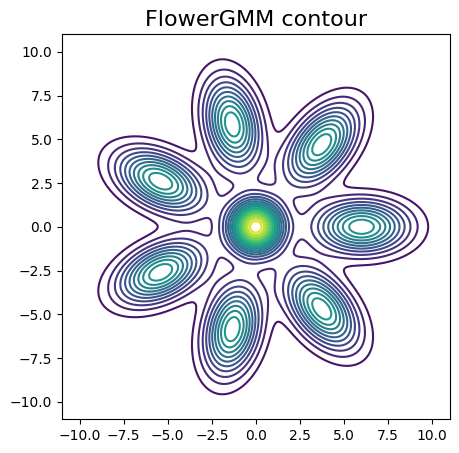

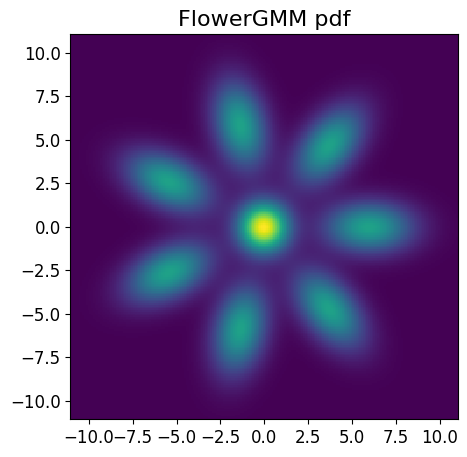

In [209]:
fgmm = FlowerGMM().to(DEVICE)
draw_distrib(fgmm, 'FlowerGMM')

In [210]:
torch.manual_seed(42)
train_data = fgmm.sample((20000,)).detach()
test_data = fgmm.sample((2000,)).detach()

/var/folders/hm/z2qrv1q973v1hnjbzpr42n3m0000gn/T/ipykernel_66176/3455873566.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self._log_pi)


### 3.4 Training

In [211]:
def steps_counter(s0, s1, res0='E', res1='M'):
    assert res0 != res1
    curr_step = 0
    steps_passed = 0
    res_mapping = [res0, res1]
    while True:
        steps_passed += 1
        if curr_step == 0:
            if steps_passed > s0:
                curr_step = 1
                steps_passed = 1
        elif curr_step == 1:
            if steps_passed > s1:
                curr_step = 0
                steps_passed = 1
        yield res_mapping[curr_step]

In [212]:
SC = steps_counter(2, 3)
next(SC)

'E'

In [213]:
SC = steps_counter(2, 3)
print([next(SC) for _ in range(7)])

['E', 'E', 'M', 'M', 'M', 'E', 'E']


In [214]:
def train_GMM_VariationalEM_separate_manner(
    gmmEMVar, 
    train_loader, 
    epochs=20, 
    E_grad_steps = 1,
    M_grad_steps = 1,
    q_lr=1e-3, 
    p_theta_lr=1e-3, 
    use_tqdm=True, 
    use_cuda=False):

    SC = steps_counter(E_grad_steps, M_grad_steps)
    q_optimizer = optim.Adam(gmmEMVar.q.parameters(), lr=q_lr)
    p_theta_optimizer = optim.Adam(gmmEMVar.p_theta.parameters(), lr=p_theta_lr)

    forrange = tqdm(range(epochs)) if use_tqdm else range(epochs)

    if use_cuda:
        gmmEMVar = gmmEMVar.cuda()

    for epoch in forrange:

        if epoch % 50 == 0:
            draw_distrib(gmmEMVar.gmm_model, 'GMM_EM_Var, Separate, epoch {}'.format(epoch), density=False)

        for x in train_loader:
            x = x.float()
            if use_cuda:
                x = x.cuda()
            # EM alogorithm, where E and M steps are being performed seperately           
            # E step
            if next(SC) == 'E':
                q_optimizer.zero_grad()
                E_loss = gmmEMVar.E_step_loss(x)
                E_loss.backward()
                q_optimizer.step()

            # M step
            else:
                p_theta_optimizer.zero_grad()
                M_loss = gmmEMVar.M_step_loss(x)
                M_loss.backward()
                p_theta_optimizer.step()

### Task:

Vary the parameters ```N_COMPONENTS```, ```EPOCHS```, ```E_GRAD_STEPS```, ```M_GRAD_STEPS```   and describe your results. How do these parameters affect the convergence of the algorithm? (**1 pt**)

  0%|          | 0/250 [00:00<?, ?it/s]

/var/folders/hm/z2qrv1q973v1hnjbzpr42n3m0000gn/T/ipykernel_66176/3455873566.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self._log_pi)
/var/folders/hm/z2qrv1q973v1hnjbzpr42n3m0000gn/T/ipykernel_66176/3206462172.py:5: UserWarning: The following kwargs were not used by contour: 'c'
  plt.contour(X, Y, density, levels=levels, c='red')


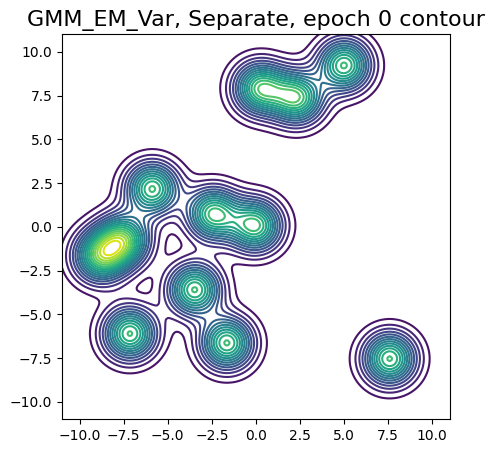

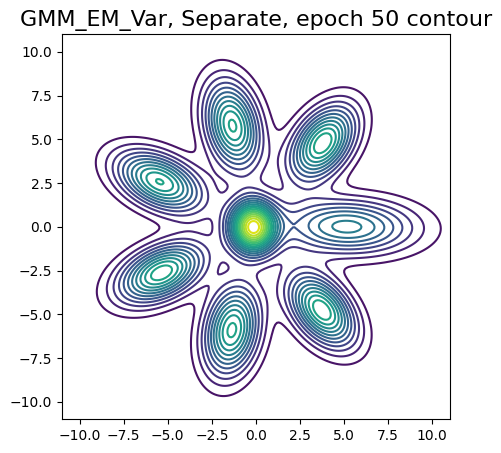

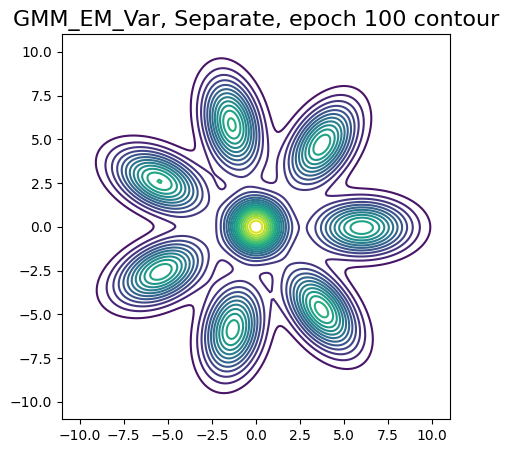

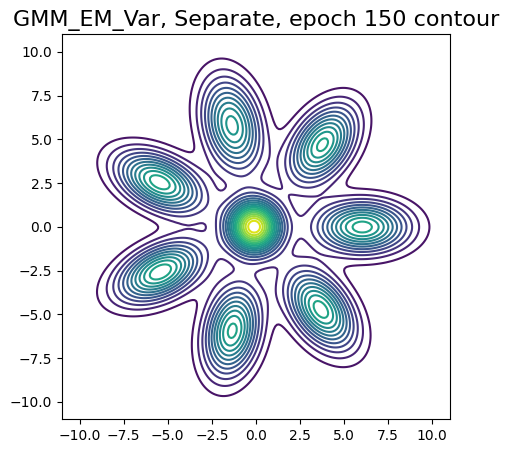

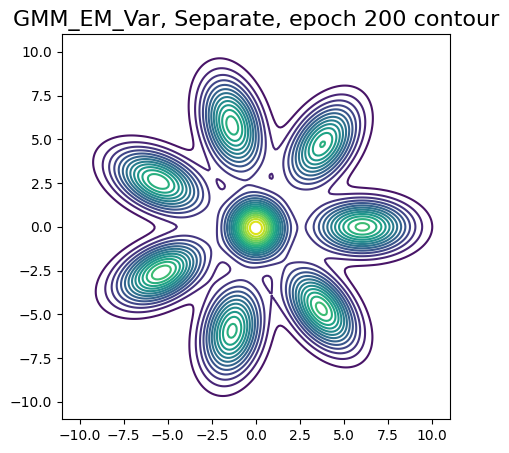

In [215]:
EPOCHS = 250
BATCH_SIZE = 128
Q_LR = 6e-3
P_THETA_LR = 6e-3
E_GRAD_STEPS = 2
M_GRAD_STEPS = 2

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)



train_GMM_VariationalEM_separate_manner(
    gmmEMVar, train_loader, EPOCHS, E_GRAD_STEPS, M_GRAD_STEPS, 
    Q_LR, P_THETA_LR, use_tqdm=True, use_cuda=False)

In [ ]:
# your answer is here

It is better to take more components, with smaller number we often converge in local minima where some components merge with each other. <br>
I would say that lr and epoch should be considered together. Taking small lr (<1e-3) leads to getting stuck in some local minima, big lr (>8e-3) makes us jump between 2 points (fails to converge). Epochs should be chosen appropriately for every lr (until convergance). <br>
With more M steps it often merges components but seems to converge faster. With more E steps it seems to be better at converging to the global minimum, but takes more iterations to fully converge. 